# Optymalizacja Bayesowska i Scikit - Optimize

Igor Zubrycki igorzubrycki@gmail.com

Chcemy zoptymalizować funkcje, które:
    
    - są czarnymi skrzynkami, z niedostępnymi gradientami czy opisem analitycznym
    - możemy tylko określać wartość tych funkcji ale nawet to jest obarczone błędem
    - ewaluacja funkcji jest bardzo droga, obliczeniowo czy finansowo
    


To co możemy zrobić to wykonać serię eksperymentów, z pewnym budżetem:

 - faktyczne eksperymenty naukowe: szukamy najlepszego środowiska dla rozwoju mikroorganizmu, szukamy ropy, zmieniamy parametry robota
 - badanie preferencji użytkowników: 
 - optymalizacja hiperparametrów: sieci neuronowe


## Skupmy się na tym ostatnim: optymalizacja hiperparametrów.


W scikit-learn mamy dostępne dwie metody: grid search i random search
    
Pierwsza, tworzy D-wymiarową siatkę parametrów o ustalonej przez nas gęstości 
w danym wymiarze i sukcesywnie ją przeszukuje (która kombinacja parametrów da najlepszy wynik, ta wygrywa)

Druga, dysponując strzela określoną ilość razy, najlepszy strzał wygrywa.

Generalnie, druga metoda daje większą szansę trafienia (Bergstra i Benigo 2012 http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf)


## Teoretycznie, jeśli nasze obliczenia są naprawdę tanie, możemy wykorzystać ** zwykłą ** opytmalizację

## Co jednak dzieje się przy **bardzo** drogich funkcjach?

Dobieranie parametrów sieci neuronowej. Jeden pełen przebieg to 1 doba, oddanie klientowi gotowego rozwiązania za miesiąc ;)

**Graduate search ** -- badacz zmienia parametry kierując się *intuicją* szukacjąc dobrej kombinacji dużej ilości parametrów (ilość warstw, normalizacja, ilość neuronów, szybkość uczenia).

Raczej nie będzie przy tym za każdym razem rzucał kostką czy nie będzie metodycznie przeszukiwał wszystkich kombinacji. 

Co w takim razie będzie robił?

-- Na początku pewnie sprawdzi parę "sprawdzonych" kombinacji
--  Później **kierując się wynikiem** tych eksperymentów będzie sprawdzał inne kombinacje jednak takie które są podobne do udanych. 
-- Czasem jednak spróbuje kombinacji która najbardziej będzie obiegała od tych których zna "dla świętego spokoju"





## Maszyna może to zrobić za nas

Bayesian search:

Strategia: próbkuj funkcję, dopasuj "tymczasową funkcję", przy okazji określ ile nie wiesz.
Tam gdzie nie wiesz a jest "szansa na maksimum", próbkuj

In [63]:
### code taken from 

%config InlineBackend.figure_format='retina'
%matplotlib inline

# Silence warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14
plt.rcParams["lines.linewidth"] = 4
plt.rcParams["lines.markersize"] = 10
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['axes.labelsize'] = 'x-large'

from ipywidgets import interact

In [41]:
def teach_optimizer(n_iter=22):
    space = Space([(-2.0, 2.0)])

    opt = Optimizer(space, n_initial_points=3, acq_func="EI",
                    acq_func_kwargs={'xi': 0.01})
    for _ in range(n_iter):
        suggested = opt.ask()
        y = objective(suggested)
        opt.tell(suggested, y)
    
    return opt

opt_memory=teach_optimizer()

In [61]:
from skopt import Optimizer
from skopt.space import Space
from importlib import reload
import utils
reload(utils)
from utils import plot_optimizer
from utils import plot_main
from utils import plot_optimizer_part

x = np.linspace(-2, 2, 300).reshape(-1, 1)
noise_level = 0.1

# Our 1D toy problem, this is the function we are trying to
# minimize
def objective(x, noise_level=noise_level):
    return (np.sin(5 * x[0]) *
            (1 - np.tanh(x[0] ** 2)) +
            np.random.randn() * noise_level)



def show_result(n_iter=1):
    np.random.seed(123)
    space = Space([(-2.0, 2.0)])

    #opt = Optimizer(space, n_initial_points=3, acq_func="EI",
    #                acq_func_kwargs={'xi': 0.01})
    
    #read from cache
    
    plot_main(opt_memory,x,n_iter=n_iter)
    plt.show()
def show_optimizer(n_iter=3):
    np.random.seed(123)
    #space = Space([(-2.0, 2.0)])

    #opt = Optimizer(space, n_initial_points=3, acq_func="EI",
    #                acq_func_kwargs={'xi': 0.01})
    
    #read from cache
    #opt.yi=opt_memory.yi[0:n_iter]
    #opt.Xi=opt_memory.Xi[0:n_iter]
    #opt.models=opt_memory.models[0:n_iter]
    '''for _ in range(n_iter):
        suggested = opt.ask()
        y = objective(suggested)
        opt.tell(suggested, y)
    '''    
    plot_optimizer_part(opt_memory, x,n_iter=n_iter)
    plt.show()

## Jak można próbkować?

In [64]:
interact(show_result,n_iter=(2, 22))


<function __main__.show_result>

### Do optymalizacji wykorzystujemy 2 funkcje:

Funkcję zastępczą: Gaussian Process
    
Funkcję akwizycji

## Gaussian Process:

Dla każdego wektora x generuje nam wartość średnią funkcji jak i wariancję.

Wartości te generowane są wykorzystując macierz kowariancji która mierzy jak podobne jest wektor x do 
wektorów poprzednio wykorzystywanych.

Z tego, zakładając że funkcja jest w miarę gładka, możemy określić wartość funkcji ( średnią)
dodatkowo dla x leżącego blisko porzednich x, możemy być bardziej pewni wartości funkcji niż dla x leżącego daleko.


## Funkcja akwizycji

Zagadnienie eksploracji/ eksploatacji. 

Dla przykładu: jestem w nowym mieście, idę do jakiejś losowej restauracji, restauracja jest ok. Czy następnego dnia iść do tej samej czy do innej?

Różne metody, pomysł podobny, zamiast tylko wykorzystywać średnią wartość funkcji, wykorzystuję moją pewność co do wyniku. 

Dla przykładu:

PI( probability of improvement): jaka jest szansa że dla określonego x poprawię się o przynajmniej epsilon

EI ( expected improvement): gdzie średnio mogę się najbardziej poprawić

UCB (upper confidence bounds): gdzie mogę się najwięcej poprawić

Tomphson sampling - wyciągam jedną funkcję z rodziny GP funkcji i szukam jej maksimum/ minimum. 

In [65]:
interact(show_optimizer,n_iter=(3, 22))


<function __main__.show_optimizer>

In [ ]:
Przykłady

## Scikit-optimize (Skopt)

Biblioteka do optymalizacji

Integruje się łatwo ze scikit-learn i z pakietami scipynumpy

Narzędzia do archiwizacji, wizualizacji wyników

Dość młode narzędzie

Tryby pracy:
    
    - jak optymalizator 
    - jak scikit-learn
    - ask and tell

Ex 1, 

Ex 2

Ask and tell

### Różne typy zmiennych ( kategoryczne, integer etc) 

### poprzednio zdobyte dane

Wizualizacja

Inne optymalizatory

## Wrapup

Optymalizacja Bayesowska pozwala na maksymalne wykorzystanie danych/ budżetu obliczeniowego

W Scikit-optimize dostajemy łatwe do wykorzystania zastępstwo Scikit-learn'owego grid-search i tryb kompletnie offline ask  tell

Nie jest to lek na całe zło same GP są dość cięzkie obliczeniowo i istnieje sporo lepszych optymalizatorów ** jeśli więcej wiemy o funkcji ew jest ona tańsza**



In [46]:
noise_level = 0.1

def f(x, noise_level=noise_level):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2)) + np.random.randn() * noise_level

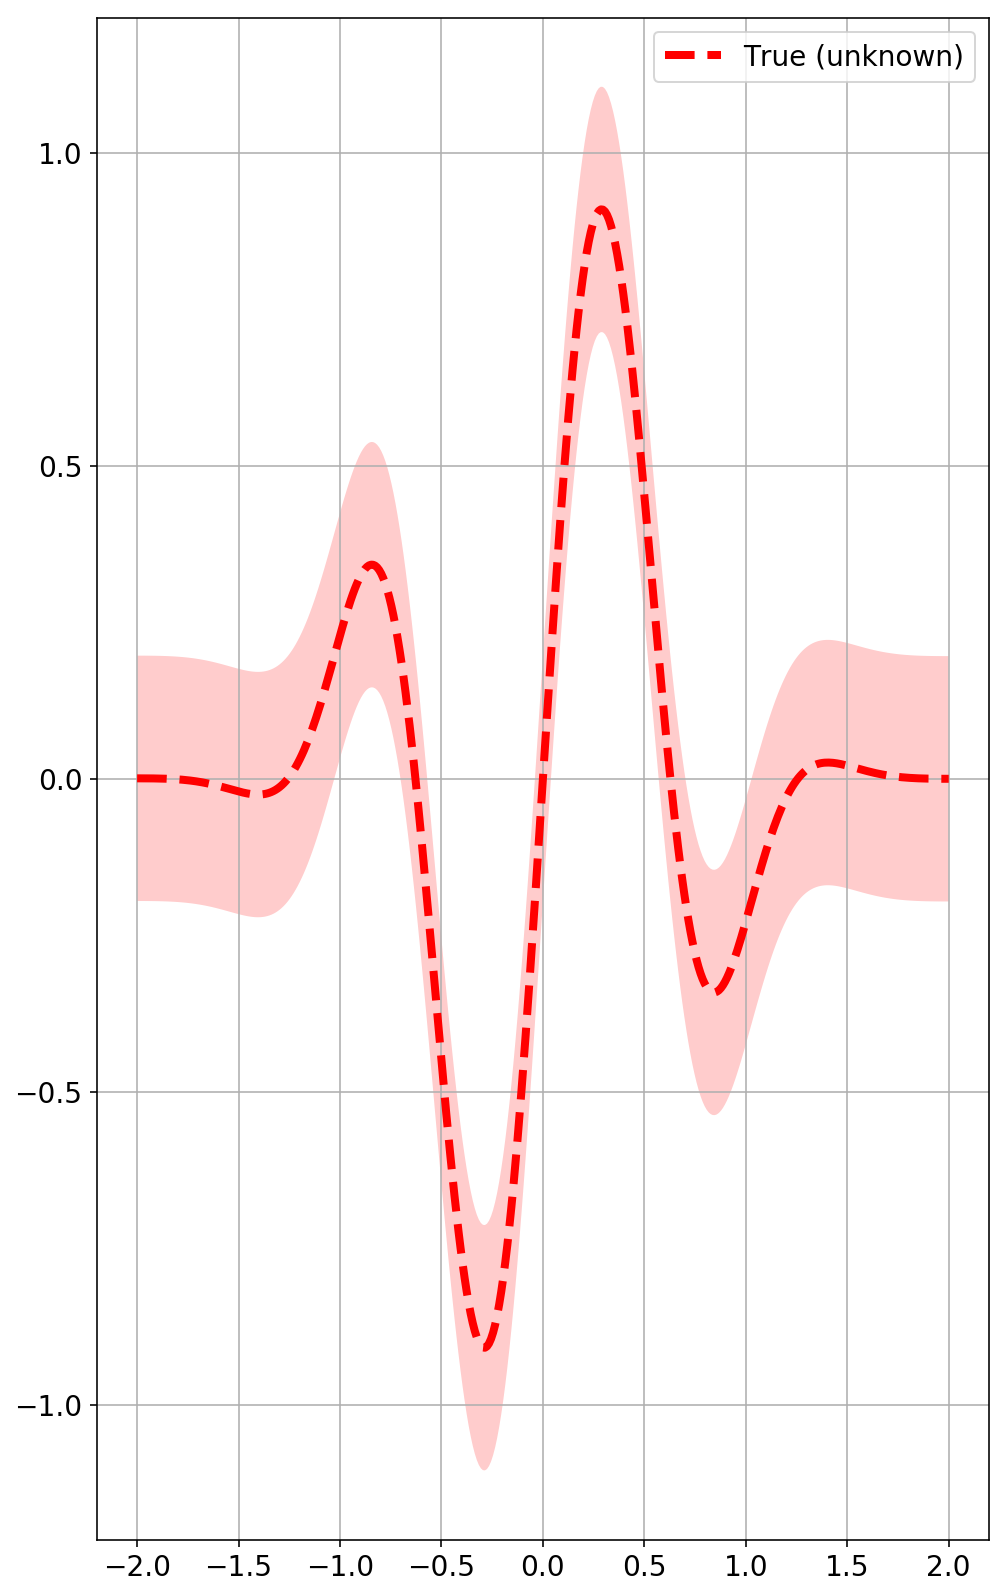

In [47]:
# Plot f(x) + contours
x = np.linspace(-2, 2, 400).reshape(-1, 1)
fx = [f(x_i, noise_level=0.0) for x_i in x]
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx], 
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")
plt.legend()
plt.grid()
plt.show()

In [48]:
from skopt import gp_minimize

res = gp_minimize(f,                  # the function to minimize
                  [(-2.0, 2.0)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=15,         # the number of evaluations of f 
                  n_random_starts=5,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  random_state=123)   # the random seed

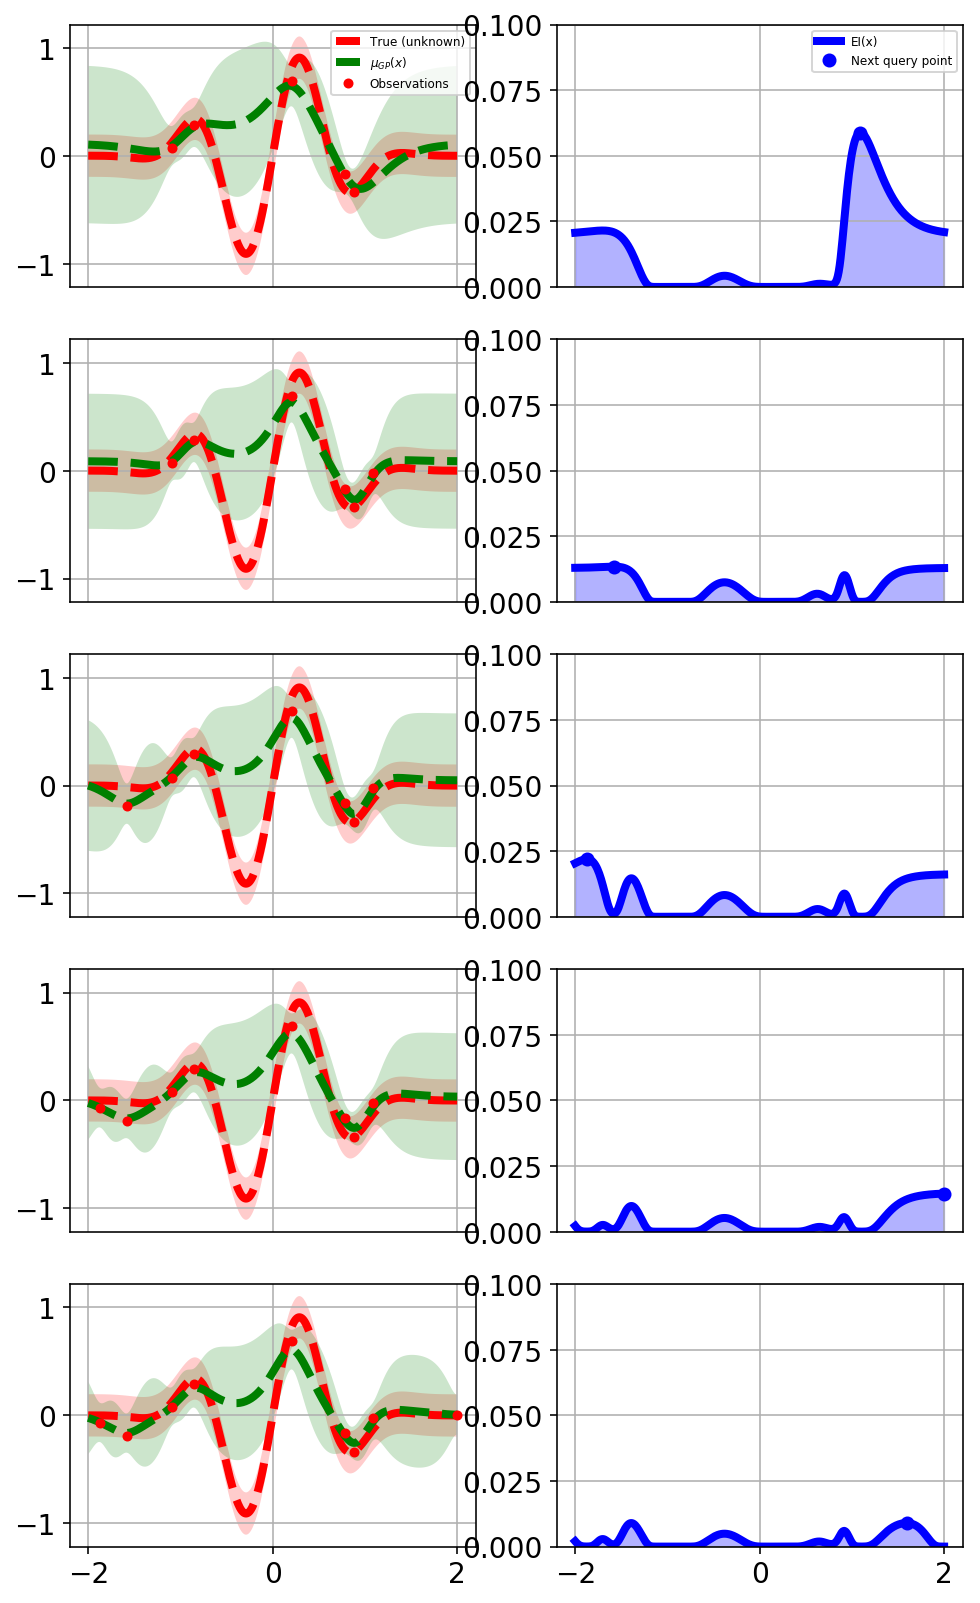

In [49]:
from skopt.acquisition import gaussian_ei

plt.rcParams["figure.figsize"] = (8, 14)

#res=opt_memory

x = np.linspace(-2, 2, 400).reshape(-1, 1)
x_gp = res.space.transform(x.tolist())
fx = np.array([f(x_i, noise_level=0.0) for x_i in x])

# Plot the 5 iterations following the 5 random points
for n_iter in range(5):
    gp = res.models[n_iter]
    curr_x_iters = res.x_iters[:5+n_iter]
    curr_func_vals = res.func_vals[:5+n_iter]

    # Plot true function.
    plt.subplot(5, 2, 2*n_iter+1)
    plt.plot(x, fx, "r--", label="True (unknown)")
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([fx - 1.9600 * noise_level, 
                             fx[::-1] + 1.9600 * noise_level]),
             alpha=.2, fc="r", ec="None")

    # Plot GP(x) + contours
    y_pred, sigma = gp.predict(x_gp, return_std=True)
    plt.plot(x, y_pred, "g--", label=r"$\mu_{GP}(x)$")
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([y_pred - 1.9600 * sigma, 
                             (y_pred + 1.9600 * sigma)[::-1]]),
             alpha=.2, fc="g", ec="None")

    # Plot sampled points
    plt.plot(curr_x_iters, curr_func_vals,
             "r.", markersize=8, label="Observations")

    # Adjust plot layout
    plt.grid()

    if n_iter == 0:
        plt.legend(loc="best", prop={'size': 6}, numpoints=1)

    if n_iter != 4:
        plt.tick_params(axis='x', which='both', bottom='off', 
                        top='off', labelbottom='off') 

    # Plot EI(x)
    plt.subplot(5, 2, 2*n_iter+2)
    acq = gaussian_ei(x_gp, gp, y_opt=np.min(curr_func_vals))
    plt.plot(x, acq, "b", label="EI(x)")
    plt.fill_between(x.ravel(), -2.0, acq.ravel(), alpha=0.3, color='blue')

    next_x = res.x_iters[5+n_iter]
    next_acq = gaussian_ei(res.space.transform([next_x]), gp, y_opt=np.min(curr_func_vals))
    plt.plot(next_x, next_acq, "bo", markersize=6, label="Next query point")

    # Adjust plot layout
    plt.ylim(0, 0.1)
    plt.grid()

    if n_iter == 0:
        plt.legend(loc="best", prop={'size': 6}, numpoints=1)

    if n_iter != 4:
        plt.tick_params(axis='x', which='both', bottom='off', 
                        top='off', labelbottom='off') 

plt.show()